## Some improvements of queries from an IBL query notebook

In [4]:
dj.list_schemas()

['ibl_acquisition',
 'ibl_action',
 'ibl_alyxraw',
 'ibl_analyses_behavior',
 'ibl_behavior',
 'ibl_data',
 'ibl_dj_acquisition',
 'ibl_dj_action',
 'ibl_dj_alyxraw',
 'ibl_dj_analyses_behavior',
 'ibl_dj_behavior',
 'ibl_dj_data',
 'ibl_dj_ingest_acquisition',
 'ibl_dj_ingest_action',
 'ibl_dj_ingest_data',
 'ibl_dj_ingest_reference',
 'ibl_dj_ingest_subject',
 'ibl_dj_plotting_behavior',
 'ibl_dj_reference',
 'ibl_dj_subject',
 'ibl_ephys',
 'ibl_ingest_acquisition',
 'ibl_ingest_action',
 'ibl_ingest_data',
 'ibl_ingest_reference',
 'ibl_ingest_subject',
 'ibl_plotting_behavior',
 'ibl_reference',
 'ibl_subject']

In [5]:
import datajoint as dj
reference = dj.create_virtual_module('reference', 'ibl_dj_reference')
subject = dj.create_virtual_module('subject', 'ibl_dj_subject')
action = dj.create_virtual_module('action', 'ibl_dj_action')
acquisition = dj.create_virtual_module('acquisition', 'ibl_dj_acquisition')
data = dj.create_virtual_module('data', 'ibl_dj_data')
behavior = dj.create_virtual_module('behavior', 'ibl_dj_behavior')

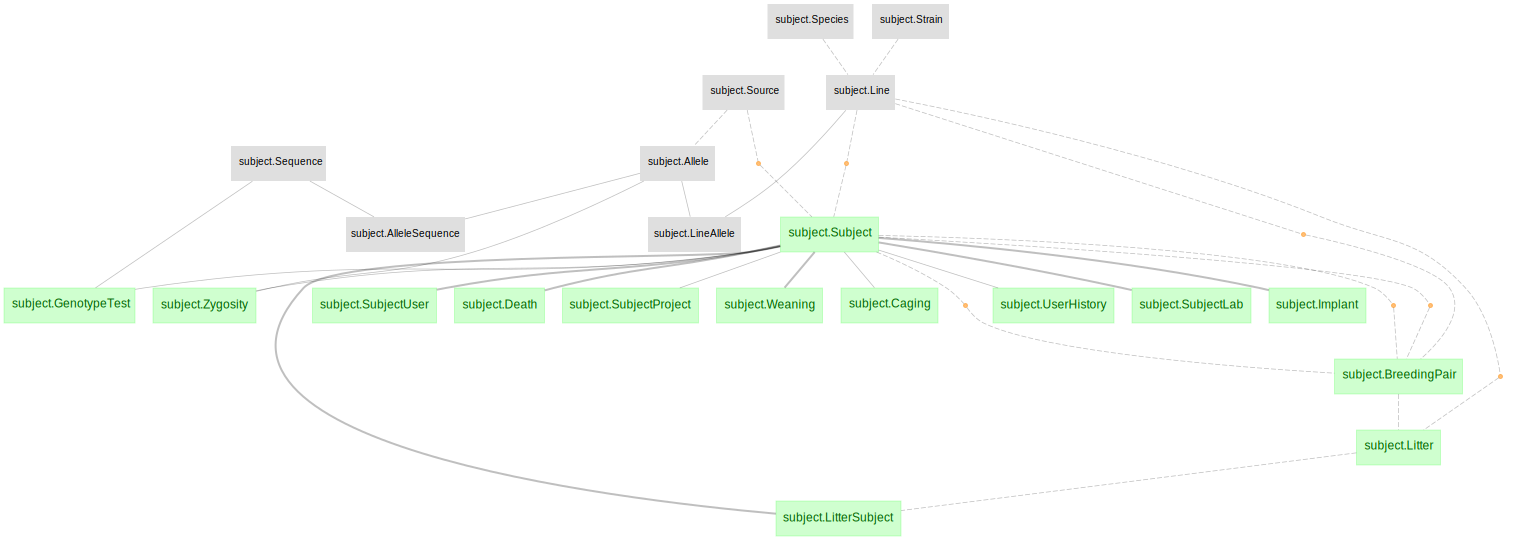

In [18]:
dj.Diagram(subject)

### ORIGINAL: 
```python
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)
```

In [2]:
# IMPROVED: 
subj = (subject.Subject * subject.SubjectLab - subject.Death & 'subject_birth_date < "2018-09-01"' & 
        {'lab_name': 'churchlandlab'}).proj('subject_nickname', 'sex')
subj

subject_uuid,subject_nickname nickname,sex sex
034c07c5-69b0-48c7-ab3e-e491e4dbb725,IBL_25,M
1208c089-8b8e-4a87-98f0-05a68fb18370,IBL_13,M
278bf922-073e-4ef4-90b5-ccf4e25e08fe,IBL_26,M
3e97e1d3-2a0f-44e5-b63f-36196d78457a,IBL_34,M
3f854f88-7879-4368-9e0d-41edea3bfab9,IBL_11,M
52a800fc-cbbc-45e9-97b1-ad6f6166e9af,IBL_1,M
55381f61-4e47-4baa-beb9-70068c0ad62c,IBL_46,M
56b81bb0-fffb-4875-9cd6-29465782fb0e,IBL_24,M
64ff6fea-89a5-449d-a9f4-53f4b200e7db,IBL_20,M
6af88109-8b3d-485c-8486-f8b35d2bf061,IBL_23,M


### ORIGINAL 

```python
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)


# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
```

In [3]:
# IMPROVED:

weight_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
avg_weight_date = dj.U('subject_uuid', 'session_date').aggr(weight_date, avg_weight='AVG(weight)')
avg_weight_date

subject_uuid,session_date calculated attribute,avg_weight calculated attribute
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-23,23.809999465942383
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-24,23.299999237060547
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-25,23.770000457763672
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-26,23.350000381469727
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-27,23.389999389648438
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-30,22.200000762939453
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-07-31,22.139999389648438
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-08-01,22.239999771118164
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-08-02,22.1200008392334
0026c82d-39e4-4c6b-acb3-303eb4b24f05,2018-08-03,22.360000610351562


### ORIGINAL

```python
# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib', 
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
```

In [4]:
# IMPROVED

water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib', 
    session_date='DATE(administration_time)')
total_water_date = dj.U('subject_uuid', 'session_date').aggr(
    water_with_date, 
    total_water='SUM(water_administered)', 
    watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
    adlib='MAX(adlib)')
total_water_date

subject_uuid,session_date calculated attribute,total_water calculated attribute,watertype calculated attribute,adlib calculated attribute
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-02-19,1.2780000269412994,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-02-21,0.7230999991297722,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-06,1.0,Water,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-07,1.0,Water,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-08,0.553600013256073,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-09,0.16830000281333923,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-11,0.5508000254631042,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-12,0.5669999718666077,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-13,1.617300033569336,Water 10% Sucrose,0
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-14,0.36000001430511475,Water 10% Sucrose,0


### ORIGINAL
```python
session_with_date = behavior.TrialSet.proj('n_trials') \
 * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-05-01"')
```

In [5]:
# IMPROVED

session_date = behavior.TrialSet.proj(
    'n_trials', session_date='DATE(session_start_time)') & 'session_date > "2019-04-01"'
session_date

subject_uuid,session_start_time start time,n_trials total trial numbers in this set,session_date calculated attribute
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-02 20:56:22,486,2019-04-02
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-03 20:46:09,996,2019-04-03
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-04 19:55:12,428,2019-04-04
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-04 20:33:46,262,2019-04-04
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-05 16:00:21,786,2019-04-05
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-08 23:19:00,772,2019-04-08
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-09 19:42:56,59,2019-04-09
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-09 19:48:29,928,2019-04-09
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-04-10 10:37:36,1003,2019-04-10
02120449-9b19-4276-a434-513886c2fb19,2019-04-02 21:06:18,958,2019-04-02


### ORIGINAL
```python
# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = total_water_date.aggr(avg_weight_date, keep_all_rows=True)
```

In [6]:
# IMPROVED
b = total_water_date.aggr(avg_weight_date, n="count(*)", keep_all_rows=True)
b

subject_uuid,session_date calculated attribute,n calculated attribute
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-02-19,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-02-21,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-06,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-07,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-08,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-09,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-11,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-12,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-13,1
00c60db3-74c3-4ee2-9df9-2c84acf84e92,2019-03-14,1
